# Initializing

### Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd /gdrive/MyDrive/
%ls

/gdrive/MyDrive
 AuroregressiveForecasting/            IncpetionFtAugWeighModel1/
 AuroregressiveForecasting48/          IncpetionFtAugWeighModel1_more_layer/
 AuroregressiveLOUGATTForecasting48/   IncpetionFtModel1/
 AuroregressivePREATTForecasting48/    IncpetionModel1/
'Colab Notebooks'/                     model_plot.png
 Cruchorecasting/                      model.png
 Dataset/                              S3CRET/
'Domande deep learning.gdoc'           SimpleLSTMForecasting/
 FinalModel/                           SimplerModel/
 Gabriele/                             StandardModel/
 IncpetionFtAugModel1/                 training/


### Import libraries

In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
import warnings
import math
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


### Set seed for reproducibility

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
dataset = pd.read_csv('Dataset/Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [6]:
# Normalize 
dataset_min = dataset.min()
dataset_max = dataset.max()
print(dataset_min)
print(dataset_max)
dataset_norm = (dataset-dataset_min)/(dataset_max-dataset_min)
dataset_norm.head()

Sponginess            -0.972080
Wonder level          -8.450380
Crunchiness          -37.581721
Loudness on impact    -9.028060
Meme creativity       -1.275860
Soap slipperiness     -6.006860
Hype root            -42.769221
dtype: float64
Sponginess            15.106680
Wonder level          18.122899
Crunchiness           41.138801
Loudness on impact    14.035980
Meme creativity        6.056360
Soap slipperiness     77.371620
Hype root             31.024420
dtype: float64


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,0.556576,0.481134,0.612986,0.468044,0.613765,0.691885,0.629100
1,0.562874,0.485320,0.611573,0.465453,0.627575,0.690471,0.626693
2,0.559777,0.476949,0.611573,0.462934,0.606973,0.682070,0.626693
3,0.559777,0.476949,0.611573,0.465453,0.606973,0.621844,0.626693
4,0.550279,0.485320,0.610160,0.465453,0.620783,0.637254,0.626693


In [7]:
def inspect_dataframe(df, columns, zoom):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col][1:zoom])
        axs[i].set_title(col)
    plt.show()


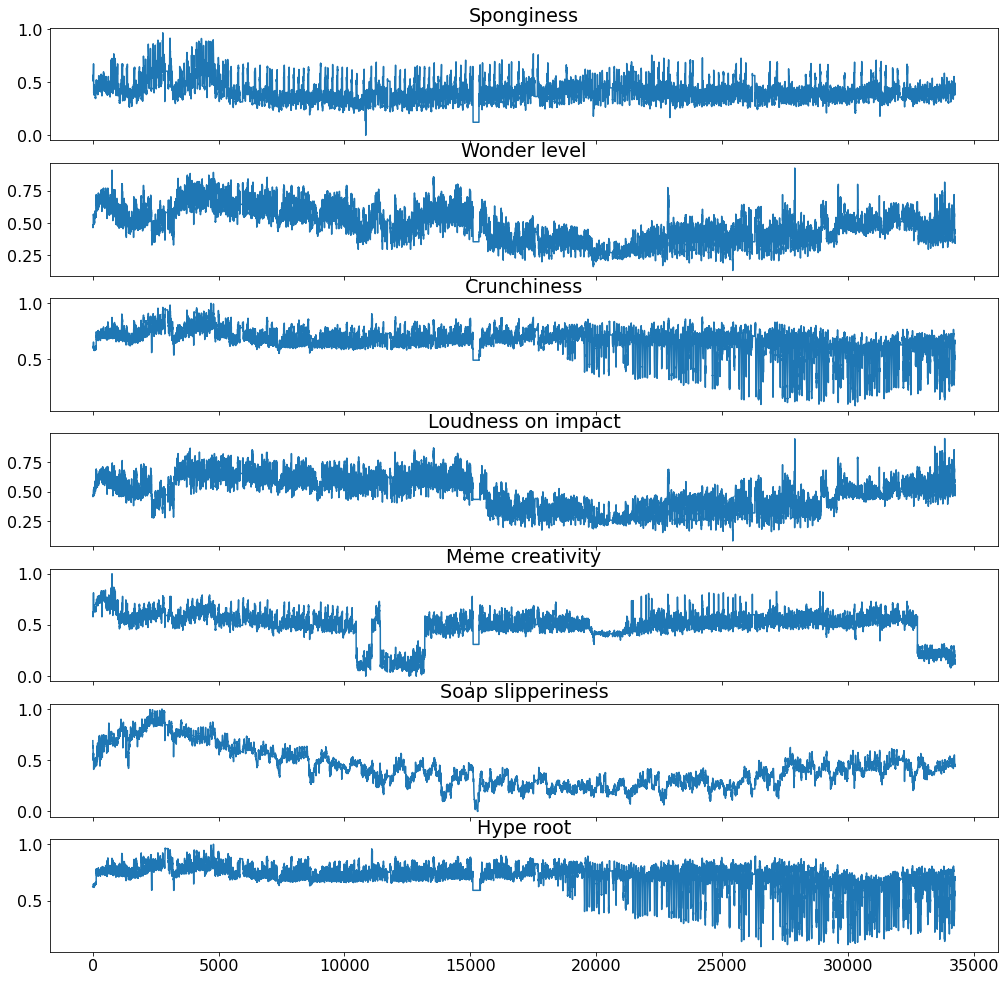

In [8]:
# Show all the dataset
inspect_dataframe(dataset_norm, dataset.columns, round((dataset.shape[0])/2))

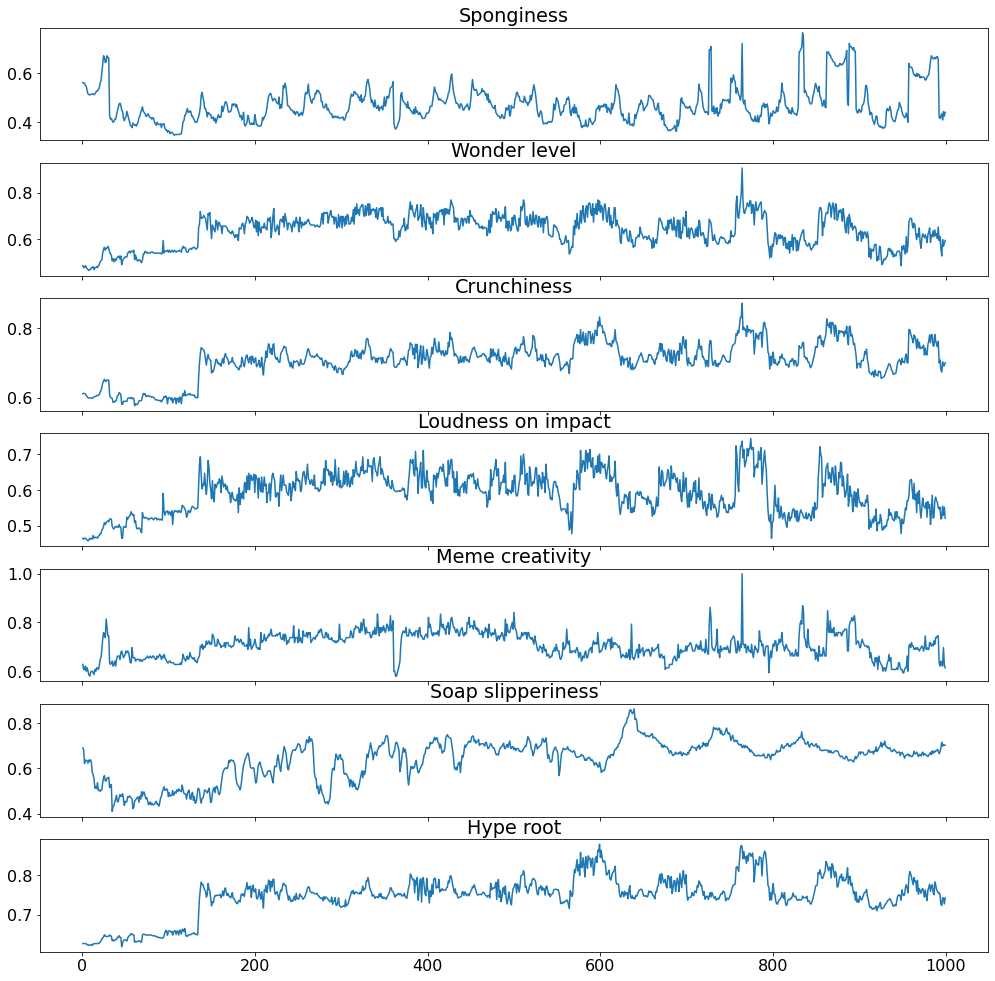

In [9]:
# Show all the dataset
inspect_dataframe(dataset_norm, dataset.columns, 1000)

may be hype root, loudness on impact, crunchiness, wonder level are positively correlated

# Feature Engineering

In [10]:
sponginess = dataset_norm['Sponginess']
wonder_level = dataset_norm['Wonder level']
crunchness = dataset_norm['Crunchiness']
load_on_impact=dataset_norm['Loudness on impact']
meme_creativity =dataset_norm['Meme creativity']
soap_slpprmness =dataset_norm['Soap slipperiness']
hype_root =dataset_norm['Hype root']

Autocorrelation plots are often used for checking randomness in time series. This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero

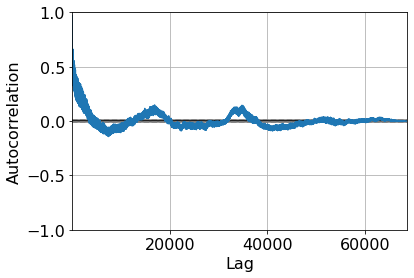

In [ ]:
from pandas.plotting import autocorrelation_plot

plt.figure();

autocorrelation_plot(sponginess)

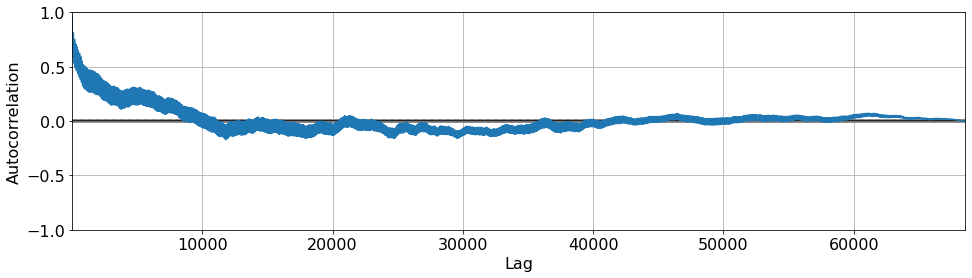

In [ ]:
autocorrelation_plot(wonder_level)

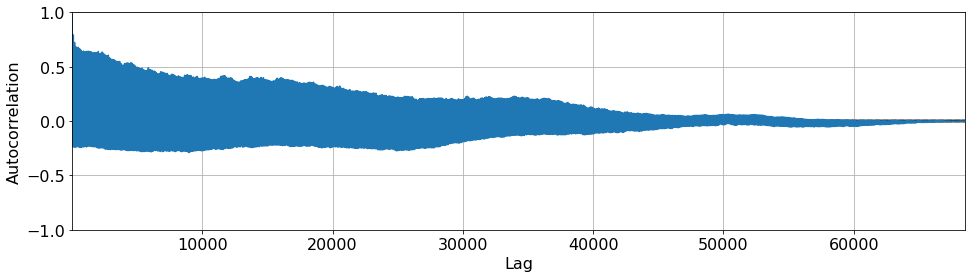

In [ ]:
autocorrelation_plot(crunchness)

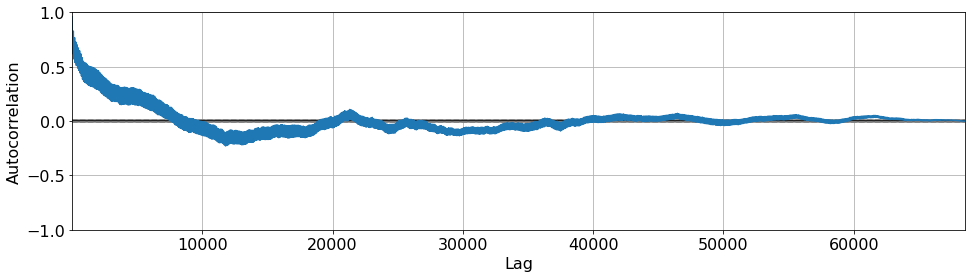

In [ ]:
autocorrelation_plot(load_on_impact)

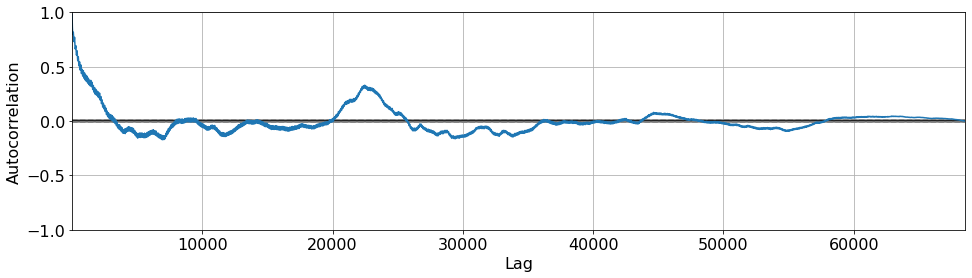

In [ ]:
autocorrelation_plot(meme_creativity)

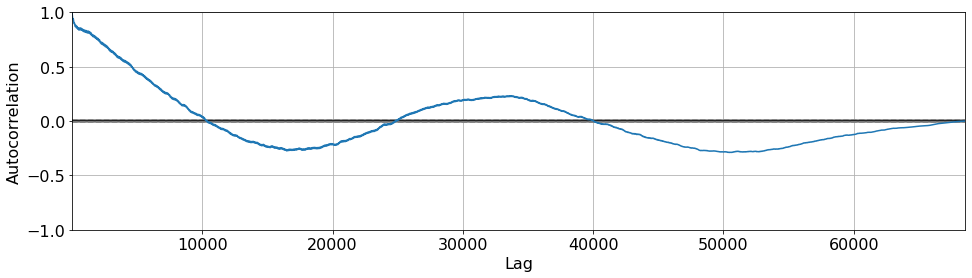

In [ ]:
autocorrelation_plot(soap_slpprmness)

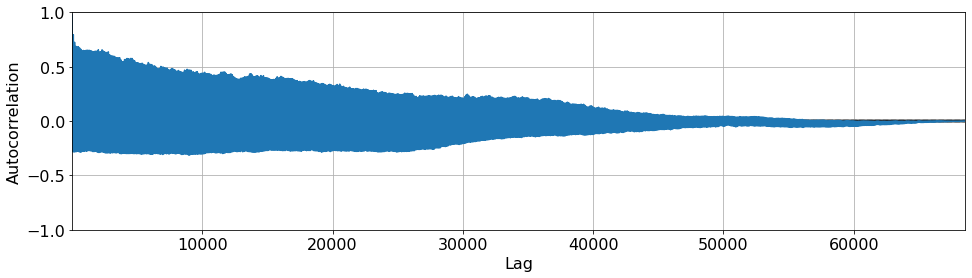

In [ ]:
autocorrelation_plot(hype_root)

Lag plots are used to check if a data set or time series is random. Random data should not exhibit any structure in the lag plot. Non-random structure implies that the underlying data are not random. The lag argument may be passed, and when lag=1 the plot is essentially data[:-1] vs. data[1:]. For a data point, if the order of the lag is one, the lag is the previous data point.

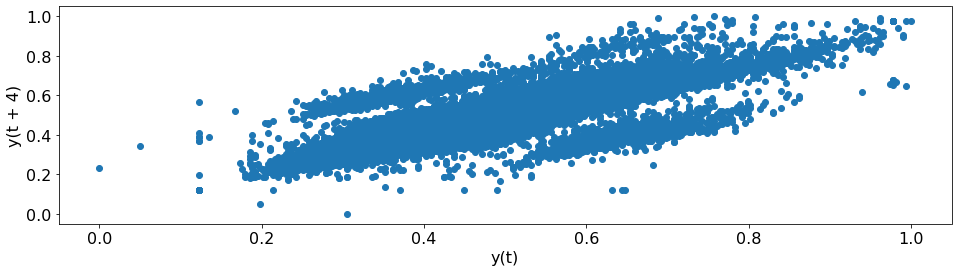

In [ ]:
from pandas.plotting import lag_plot
lag_plot(sponginess, lag = 4);

In [ ]:
sponginess[:-1][0:10]

0    0.556576
1    0.562874
2    0.559777
3    0.559777
4    0.550279
5    0.547181
6    0.528288
7    0.515693
8    0.512595
9    0.512595
Name: Sponginess, dtype: float64

In [ ]:
sponginess[:1][0:10]

0    0.556576
Name: Sponginess, dtype: float64

cluster until lag 4

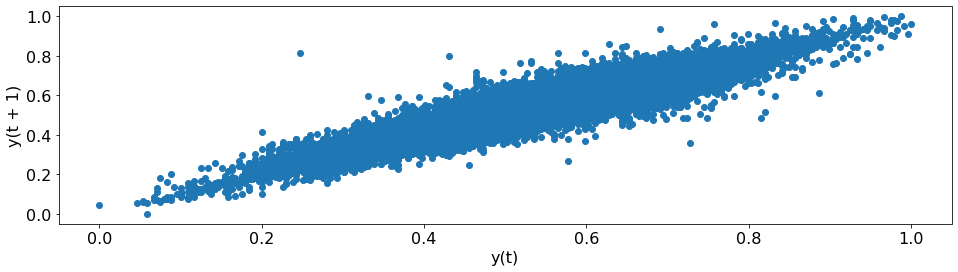

In [ ]:
lag_plot(wonder_level, lag = 1);

linear relationship until lag7/8 more visible in lag 1

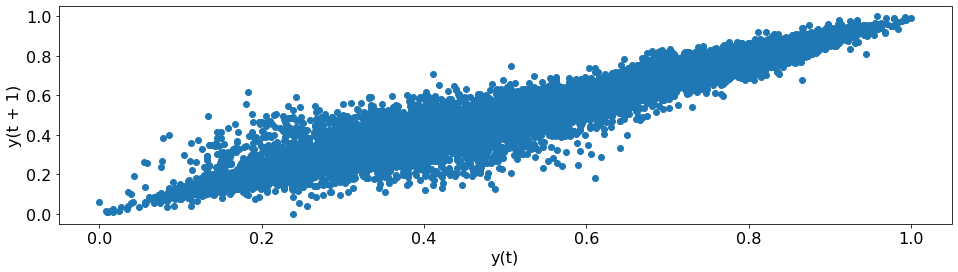

In [ ]:
lag_plot(crunchness, lag = 1);

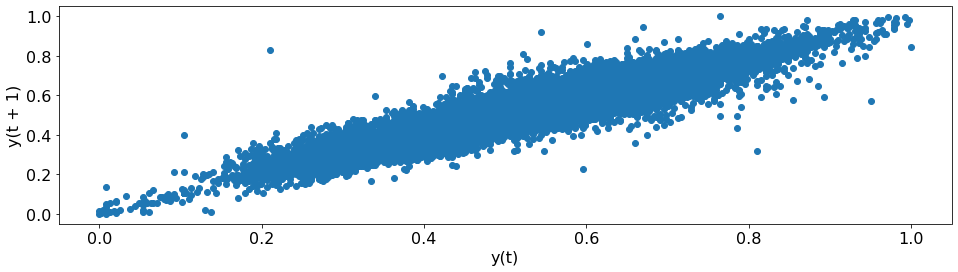

In [ ]:
lag_plot(load_on_impact, lag = 1);

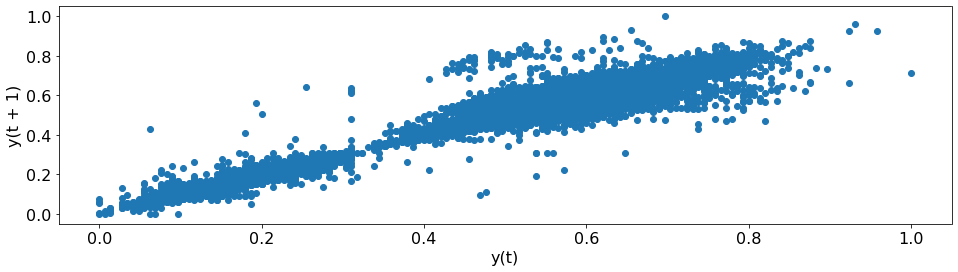

In [ ]:
lag_plot(meme_creativity, lag = 1);

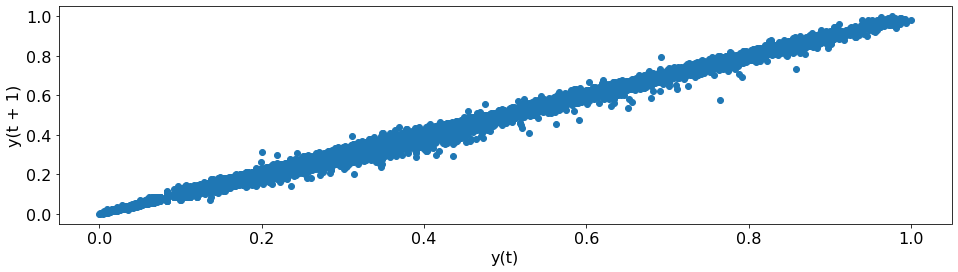

In [ ]:
lag_plot(soap_slpprmness, lag = 1);

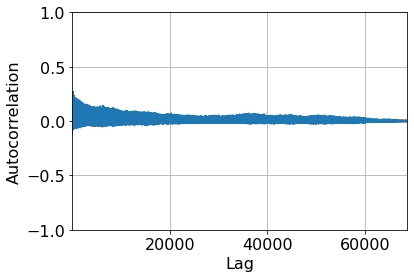

In [ ]:
autocorrelation_plot(sponginess.diff().fillna(0))

In [14]:
data_diff = dataset_norm.diff().fillna(0)
data_diff.head(10)

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.006298,0.004185,-0.001413,-0.002591,0.013810,-0.001414,-0.002407
2,-0.003097,-0.008371,0.000000,-0.002519,-0.020602,-0.008402,0.000000
3,0.000000,0.000000,0.000000,0.002519,0.000000,-0.060225,0.000000
4,-0.009498,0.008371,-0.001413,0.000000,0.013810,0.015410,0.000000
5,-0.003097,-0.008371,-0.004239,-0.002519,-0.020829,-0.001394,-0.000787
6,-0.018893,-0.004185,-0.002826,-0.002591,0.013810,-0.001414,-0.002407
7,-0.012595,-0.004185,-0.004239,-0.002519,-0.013810,-0.011189,0.000000
8,-0.003097,-0.004185,0.000000,0.002519,-0.013810,0.013996,-0.001597
9,0.000000,0.004185,0.000000,0.005110,-0.006792,-0.005594,0.001597


In [15]:
data_diff = data_diff.rename(columns={'Sponginess':	'Sponginess_diff',
                      'Wonder level': 'Wonder level_diff',	
                      'Crunchiness'	: 'Crunchiness_diff',
                      'Loudness on impact': 'Loudness on impact_diff',	
                      'Meme creativity'	: 'Meme creativity_diff',
                      'Soap slipperiness'	: 'Soap slipperiness_diff',
                      'Hype root' : 'Hype root_diff'})

In [16]:
dataset_diff = pd.concat([dataset_norm,data_diff], axis=1)
dataset_diff.head()

,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root,Sponginess_diff,Wonder level_diff,Crunchiness_diff,Loudness on impact_diff,Meme creativity_diff,Soap slipperiness_diff,Hype root_diff
0,0.556576,0.481134,0.612986,0.468044,0.613765,0.691885,0.629100,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.562874,0.485320,0.611573,0.465453,0.627575,0.690471,0.626693,0.006298,0.004185,-0.001413,-0.002591,0.013810,-0.001414,-0.002407
2,0.559777,0.476949,0.611573,0.462934,0.606973,0.682070,0.626693,-0.003097,-0.008371,0.000000,-0.002519,-0.020602,-0.008402,0.000000
3,0.559777,0.476949,0.611573,0.465453,0.606973,0.621844,0.626693,0.000000,0.000000,0.000000,0.002519,0.000000,-0.060225,0.000000
4,0.550279,0.485320,0.610160,0.465453,0.620783,0.637254,0.626693,-0.009498,0.008371,-0.001413,0.000000,0.013810,0.015410,0.000000


# Model

In [11]:
TELESCOPE = 864
WINDOWS_LENGTH = 2000
VALIDATION_SPLIT = 0.2

In [17]:
future = dataset_norm.iloc[-WINDOWS_LENGTH:, :7] #consider only the first 7 features
future = np.expand_dims(future, axis=0)
future.shape

(1, 2000, 7)

In [18]:
def build_sequences(df, target_labels, window=2000, stride=20, telescope=864): #1156/4 = 288 time-steps into the future
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float32')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [22]:
target_labels = dataset_diff.columns[:7]

In [21]:
dataset_diff.columns[:7]

Index(['Sponginess', 'Wonder level', 'Crunchiness', 'Loudness on impact',
       'Meme creativity', 'Soap slipperiness', 'Hype root'],
      dtype='object')

In [23]:
X_train, y_train = build_sequences(dataset_diff, target_labels, window =WINDOWS_LENGTH, telescope = TELESCOPE)
X_val = X_train[-math.floor(len(X_train)*VALIDATION_SPLIT):,:,:]
y_val = y_train[-math.floor(len(y_train)*VALIDATION_SPLIT):,:,:]
X_train = X_train[0:len(X_train)-math.floor(len(X_train)*VALIDATION_SPLIT), : , :] 
y_train = y_train[0:len(y_train)-math.floor(len(y_train)*VALIDATION_SPLIT), : , :]


In [24]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((2686, 2000, 14), (2686, 864, 7), (671, 2000, 14), (671, 864, 7))

In [25]:
 y_train = y_train[:, : ,:7]
 y_val = y_val[:, :, :7]
 y_train.shape, y_val.shape

((2686, 864, 7), (671, 864, 7))

In [26]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(64, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(TELESCOPE*14,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([TELESCOPE, 7])
])

multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[ tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
epochs= 200
history_6 = multi_lstm_model.fit(
    x = X_train,
    y = y_train,
    batch_size = 64,
    epochs = epochs,
    shuffle = False,
    validation_data=(X_val, y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history